In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy import interpolate
import os
import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.font_manager as fm
import tabulate
import matplotlib
import scipy.stats
import networkx as nx
import itertools
from sklearn import metrics
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import radius_neighbors_graph
import matplotlib.patches as mpatches
import sklearn.neighbors
from scipy.spatial import distance
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from mpl_toolkits.axes_grid1 import ImageGrid
from collections import Counter
import skimage
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
import io
import numpy as np
import gget
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from skimage.color import rgb2hed, hed2rgb

import sys
sys.path.append("../")
import utils as ut

from mpl_toolkits.mplot3d import Axes3D

In [2]:
# upload the scale factors

keys = ['ND', 'HFD8', 'HFD14']

scales = []

for key in keys:
    path = f"/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/{key}/outs/spatial/scalefactors_json.json"
    
    tmp = pd.read_json(path, lines=True)
    tmp['key'] = key
    # tmp['lowres_spot_diameter_pixels'] = tmp['spot_diameter_fullres'] * tmp['tissue_lowres_scalef']
    # tmp['lowres_spot_diameter_units'] = tmp['lowres_spot_diameter_pixels'] * 65
    
    scales.append(tmp)
    
scales = pd.concat(scales, ignore_index=True)
print(scales)
# print(scales[['key', 'spot_diameter_fullres', 'lowres_spot_diameter_pixels']])



def getscalebar(key, length, scales=scales):
    """Length is physical units """
    lookup = scales.loc[scales['key'] == key]
    pixels = lookup['spot_diameter_fullres'].values[0]
    scaleFactor = lookup['tissue_hires_scalef'].values[0]
    units = 55 # mircons
    fullResPixels = (pixels * length) / units
    lowResPixels = fullResPixels * scaleFactor
    return lowResPixels

def transScaleBar(hiresX, ultrahiresX, lowResPixels):
    """A function to resize the scale bar based on the 
    ultra hir-res image shape """
    newPixels = (lowResPixels * ultrahiresX) / hiresX
    return newPixels

getscalebar('ND', length=100)

   spot_diameter_fullres  tissue_hires_scalef  fiducial_diameter_fullres   
0             257.195160             0.050684                 415.469120  \
1             257.368127             0.051089                 415.748513   
2             257.404844             0.049124                 415.807825   

   tissue_lowres_scalef    key  
0              0.015205     ND  
1              0.015327   HFD8  
2              0.014737  HFD14  


23.701345795450475

In [3]:
imDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/images/lowres/"

lowres = {}
for f in os.listdir(imDir):
    if f.endswith("png"):
        fullpath = f"{imDir}{f}"
        img = skimage.io.imread(fullpath, as_gray=True)
        key = f.replace(".png", "")
        print(key, img.shape)
        lowres[key] = img

print('done')

HFD14 (2000, 1628)
ND (2000, 1681)
HFD8 (2000, 1692)
done


In [4]:
imDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/images/lowres/"

he = {}
for f in os.listdir(imDir):
    if f.endswith("png"):
        fullpath = f"{imDir}{f}"
        img = skimage.io.imread(fullpath)
        img = rgb2hed(img) # convert to h&e
        key = f.replace(".png", "")
        print(key, img.shape)
        he[key] = img

print('done')

HFD14 (2000, 1628, 3)
ND (2000, 1681, 3)
HFD8 (2000, 1692, 3)
done


In [5]:
imDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/images/hires/"

keyMap = {
    '1105-LM-1C' : 'HFD8',
    '1105-LM-1D' : 'HFD14', 
    '1105-LM-1B' : 'ND',
}

hires = {}

for f in os.listdir(imDir):
    if f.endswith("tif"):
        SPTkey = f.replace(".tif", "")
        if not SPTkey in keyMap.keys():
            continue
        
        fullpath = f"{imDir}{f}"
        img = skimage.io.imread(fullpath, as_gray=True)
        key = keyMap[SPTkey]
        print(key, img.shape)
        hires[key] = img

print('done')

HFD8 (39147, 33122)
HFD14 (40713, 33149)
ND (39460, 33174)
done


In [6]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rf  = ut.normalize(rf, 1e6)
    rna[key] = rf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

done


In [7]:
cardOutDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDOuputs/"

dfList = []

for f in os.listdir(cardOutDir):
    if 'global' in f:
        fullPath = f"{cardOutDir}{f}"
        key = f.split("_")[0]
        df = pd.read_csv(fullPath)
        df = df.rename(columns={'Unnamed: 0' : 'spotId'})
        df['key'] = key
        dfList.append(df)

df = pd.concat(dfList, ignore_index=True)
print(f"{df.shape=}")
print(df['key'].value_counts())


sptDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

normalize = True

spt = {}

for f in os.listdir(sptDir):
    if "spt" in f and "global" in f:
        print(f)
        fullPath = f"{sptDir}{f}"
        key = f.split("_")[0]
        sdf = pd.read_csv(fullPath)
        sdf = sdf.rename(columns={'Unnamed: 0' : 'gene'})
        sdf = sdf.set_index('gene')
        sdf = sdf.T
        # sdf.index = sdf.index.str.replace("-", ".")
        if normalize:
            sdf = ut.normalize(sdf)
        spt[key] = sdf
    
coordDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

dfList = []

for f in os.listdir(coordDir):
    if "coord" in f and "global" in f:
        fullPath = f"{coordDir}{f}"
        key = f.split("_")[0]
        cdf = pd.read_csv(fullPath)
        cdf = cdf.rename(columns={'Unnamed: 0' : 'spotId'})
        cdf['key'] = key
        dfList.append(cdf)

cdf = pd.concat(dfList, ignore_index=True)
print(f"{cdf.shape=}")
print(cdf['key'].value_counts())
print()

"""Merge CARD predictions with spatial coordinates"""
df = pd.merge(cdf, df,
              how='left', 
              left_on=['spotId', 'key'],
              right_on=['spotId', 'key'])

df = df.fillna(0)
df = df.drop_duplicates(subset='spotId') # very important!
print(df['key'].value_counts())
df.head()

df.shape=(7418, 13)
key
HFD8     3391
ND       2034
HFD14    1993
Name: count, dtype: int64
HFD8_global_spt.csv
ND_global_spt.csv
HFD14_global_spt.csv
cdf.shape=(7424, 4)
key
HFD8     3394
ND       2036
HFD14    1994
Name: count, dtype: int64

key
HFD8     3394
ND       2036
HFD14    1994
Name: count, dtype: int64


,spotId,x,y,key,B cells,Mac1,Mac3,Monocytes,T cells,NK cells,Stromal cells,Dendritic cells,Mac4,Mac2,Mac5
0,AAACAAGTATCTCCCA.1_HFD8,1244.795278,1189.669724,HFD8,0.077635,0.022735,0.104811,0.111453,0.125867,0.195064,0.059765,0.111978,0.082445,0.066571,0.041676
1,AAACACCAATAACTGC.1_HFD8,405.548324,1349.579809,HFD8,0.076987,0.041831,0.047343,0.139484,0.082711,0.093085,0.148247,0.071763,0.058744,0.142045,0.097760
2,AAACAGCTTTCAGAAG.1_HFD8,303.880251,1068.178931,HFD8,0.079216,0.043327,0.075868,0.086821,0.086695,0.097747,0.186142,0.090520,0.069670,0.094246,0.089748
3,AAACAGGGTCTATATT.1_HFD8,344.496391,1138.478061,HFD8,0.037682,0.029618,0.093281,0.109521,0.052151,0.061401,0.201332,0.094533,0.143671,0.088173,0.088637
4,AAACAGTGTTCCTGGG.1_HFD8,648.734268,1595.524585,HFD8,0.092691,0.001555,0.002745,0.075636,0.054631,0.052849,0.112912,0.008552,0.258918,0.056771,0.282740


# Image classification

In [8]:
img = lowres['HFD14']

nClasses = 4
thresholds = skimage.filters.threshold_multiotsu(img, classes=nClasses)

# Using the threshold values, we generate the region
regions = np.digitize(img, bins=thresholds)
# training_labels = np.where((regions == 0) | (regions == 1), 1, regions) 
training_labels = regions + 1

sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True,
                        edges=False, 
                        texture=True,
                        sigma_min=sigma_min,
                        sigma_max=sigma_max)
                        # channel_axis=-1)

features = features_func(img)

clf = RandomForestClassifier(n_estimators=50,
                             n_jobs=-1,
                             max_depth=10, 
                             max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

### run the random forest on all images
segment = {}

for i, key in enumerate(keys):
    img = lowres[key]
    features = features_func(img)
    result = future.predict_segmenter(features, clf)
    segment[key] = result
    
    
print('done')

done


In [9]:
# # hidef predict
# pos = {
#     'ND' : (14614, 12286),
#     'HFD8' : (13049, 11040),
#     'HFD14' : (14571, 11049),
# }

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 7, 5
# plt.rcParams['figure.facecolor'] = "w"

# fig, axs = plt.subplots(2, 3)

# colors = ["red", "cyan", "dimgrey", "w"]
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# ws = 1000
# microns = 100

# for i, key in enumerate(keys):
#     ultra = hires[key]
#     img = lowres[key]

#     sbarHires = getscalebar(key, microns)
#     sbarUltra = transScaleBar(img.shape[0], ultra.shape[0], sbarHires)
    
#     x, y = pos[key]    
#     window = ultra[x-ws:x+ws,y-ws:y+ws]  

#     # run prediction
#     features = features_func(window)
#     result = future.predict_segmenter(features, clf)
    
#     axs[0, i].imshow(window, cmap='binary_r')
#     axs[0, i].set_yticks([])
#     axs[0, i].set_xticks([])

#     # plot to segemented image
#     axs[1, i].imshow(result, cmap=cmap)
#     axs[1, i].set_yticks([])
#     axs[1, i].set_xticks([])
    
#     if i == 0:
#         scalebar = AnchoredSizeBar(axs[1, 0].transData,
#                                sbarUltra, 
#                                f'{microns}' + r'$\mu m$', 
#                                loc='lower left', 
#                                color='k',
#                                frameon=False,
#                                size_vertical=1,
#                                bbox_to_anchor=(0.5, 0.5, 0, 0),
#                                fontproperties={'size':7})
#         axs[1, 0].add_artist(scalebar)

# plt.tight_layout()

(0.0, 1.0, 0.0, 1.0)

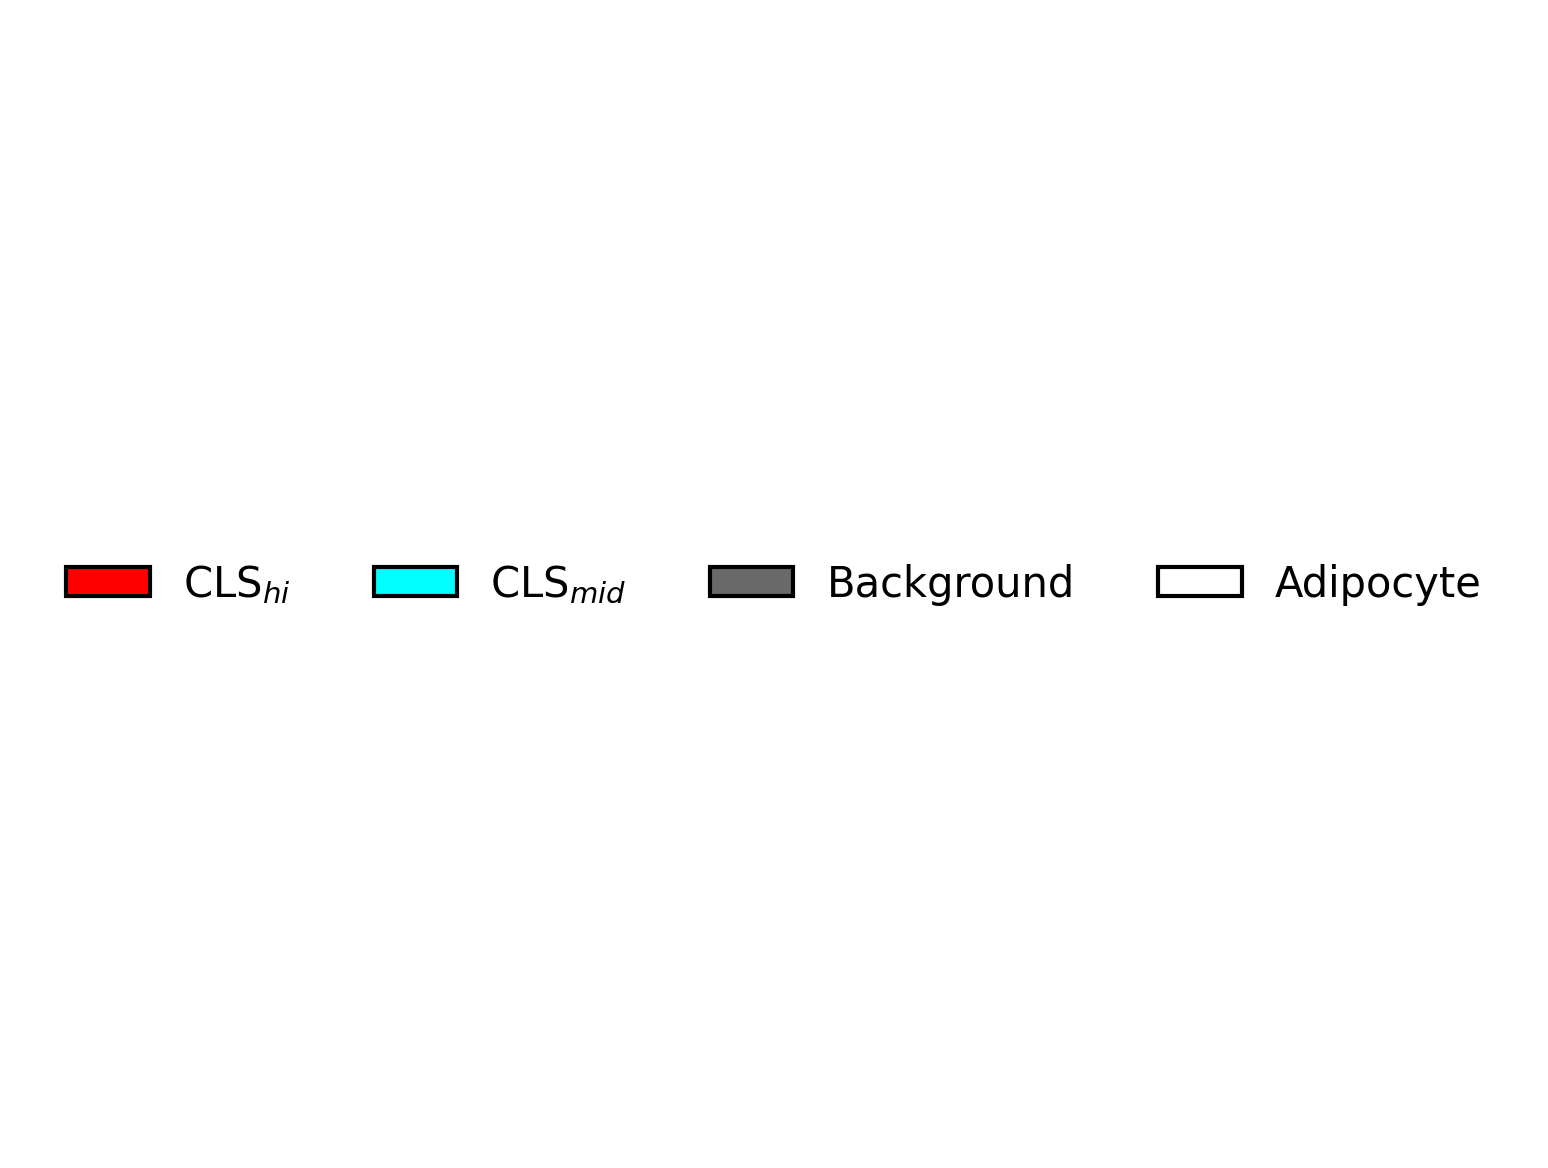

In [11]:
handles = []
colors = ["red", "cyan", "dimgrey", "w"]

labelMap = {
    1 : "CLS$_{hi}$",
    2 : "CLS$_{mid}$",
    3 : "Background",
    4 : "Adipocyte",
}

for r, c in zip(np.unique(training_labels), colors):
    elem = Patch(color=c, 
                 ec='k', 
                 label=labelMap[r])
    handles.append(elem)
    
plt.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots()
ax.legend(handles=handles, 
          loc='center', 
          ncols=4,
          frameon=False,)
             
plt.gca().axis(False)

# global image quant

In [12]:

sampleSize = 100
microns = 500 # the physical size of the window

res = []

for key in keys:
    
    # get window size based on physical units
    ultra = hires[key]
    img = lowres[key]
    pixelsPerMicron = getscalebar(key, 1)
    ws = int((microns * pixelsPerMicron) / 2)
    
    
    print(f"{microns=} {pixelsPerMicron=:.3f} {ws=}")
    
    kdf = df[df['key'] == key].reset_index(drop=True)
    sf = kdf.sample(sampleSize)
    
    # fillImg = hires[key]
    fillImg = lowres[key]
    
    for idx, row in sf.iterrows():
        # get coordinates
        x = int(row['x'])
        y = int(row['y'])
        xLb = int(x) - ws
        xUb = int(x) + ws   
        yLb = int(y) - ws   
        yUb = int(y) + ws
        
        # predict on window
        window = fillImg[yLb:yUb, xLb:xUb]
        features = features_func(window)
        result = future.predict_segmenter(features, clf)
        
        # store results
        newRow = {}       
        for k, v in Counter(result.ravel()).items():
            newRow[k] = v / window.size
        
        newRow['key'] = key
        newRow['spotId'] = row['spotId']
        res.append(newRow)

res = pd.DataFrame(res)
res.head()

microns=500 pixelsPerMicron=0.237 ws=59
microns=500 pixelsPerMicron=0.239 ws=59
microns=500 pixelsPerMicron=0.230 ws=57


,3,4,2,1,key,spotId
0,0.200445,0.717682,0.064924,0.016949,ND,GTCATTAGAGCGAACG.1_ND
1,0.141770,0.791152,0.056880,0.010198,ND,GGGAAGGGCTTTCTCA.1_ND
2,0.099397,0.872307,0.023628,0.004668,ND,TTGCGTCGGCCAACCG.1_ND
3,0.164752,0.764579,0.056665,0.014005,ND,ACTCTGACCTAATAGA.1_ND
4,0.169420,0.775208,0.045748,0.009624,ND,GGCTATTAAGTTGTAT.1_ND


Text(0, 0.5, 'Proportion Pixels per 500$\\mu m^2$')

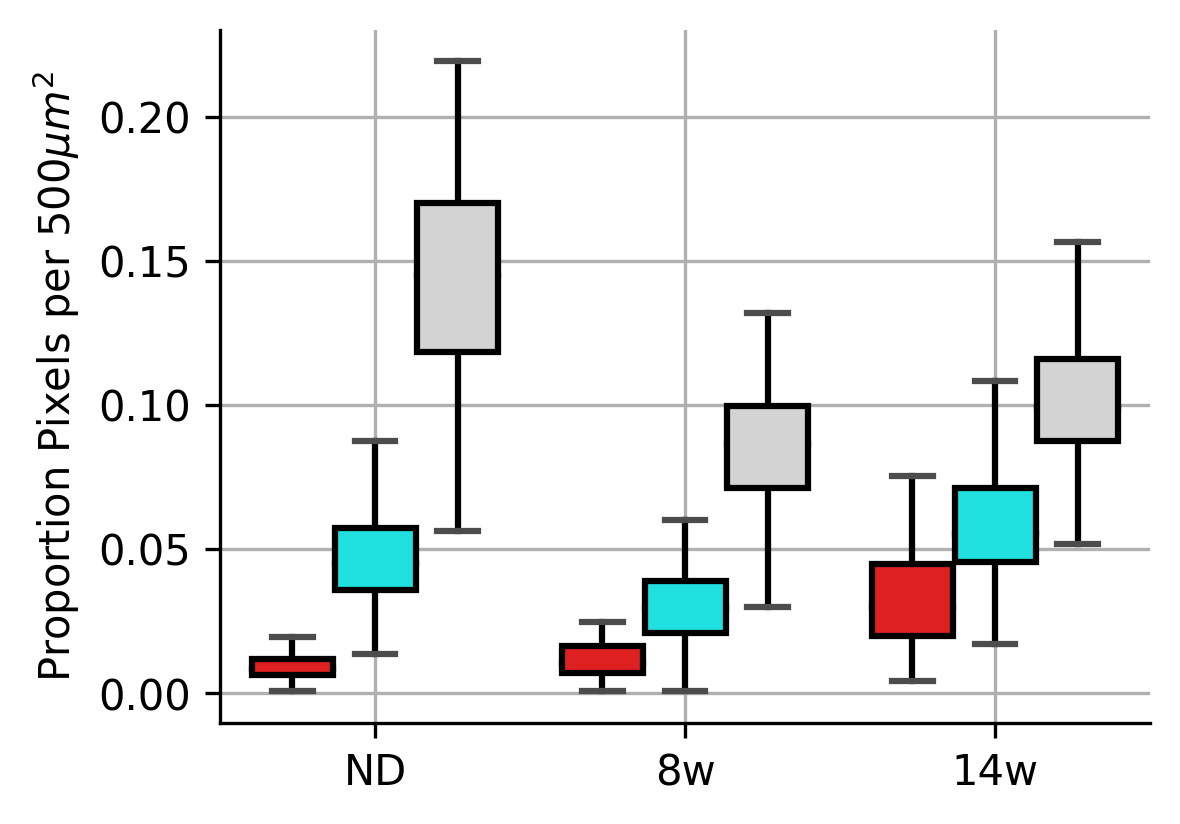

In [13]:
pdf = res.copy()
pdf = pd.melt(pdf, id_vars=['key', 'spotId'])

pdf = pdf[pdf['variable'] != 4]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3
plt.rcParams['figure.facecolor'] = "w"

colors = ['red', 'cyan', 'lightgrey', "w"]

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

pdf['keyName'] = pdf['key'].map(keyMap)

sns.boxplot(data=pdf, 
            y='value',
            x='keyName',
            hue='variable', 
            boxprops={'edgecolor':'k', 'zorder':3},
            medianprops={'color':'k'},
            whiskerprops={'color':'k'},
            palette=colors[0:3],
            showfliers=False)

plt.gca().grid(True, zorder=0)
sns.despine()
plt.gca().legend().remove()

pdf.head()
plt.xlabel("")
plt.ylabel(f"Proportion Pixels per {microns}$\mu m^2$")

Text(0, 0.5, 'Proportion Pixels per 500$\\mu m^2$')

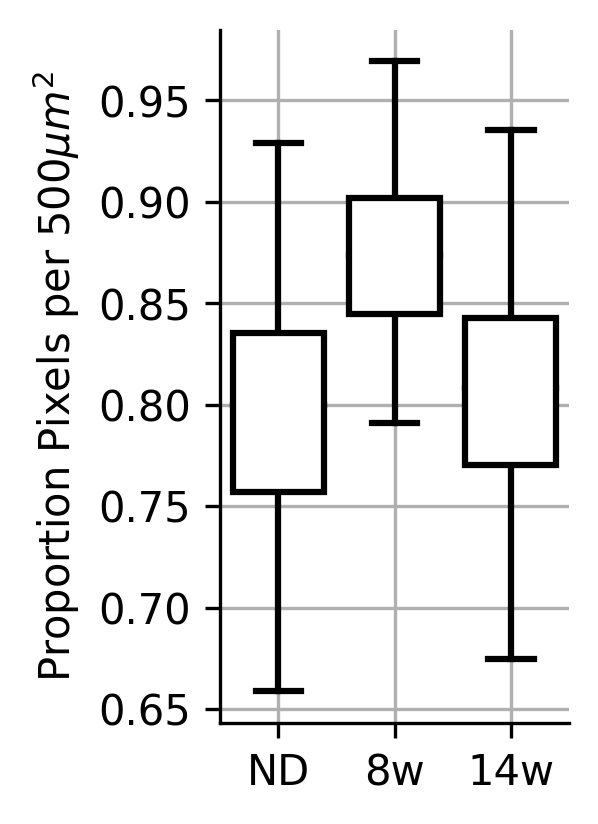

In [14]:
pdf = res.copy()
pdf = pd.melt(pdf, id_vars=['key', 'spotId'])

pdf = pdf[pdf['variable'] == 4]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.5, 3
plt.rcParams['figure.facecolor'] = "w"

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

pdf['keyName'] = pdf['key'].map(keyMap)

sns.boxplot(data=pdf, 
            y='value',
            x='keyName',
            hue='variable', 
            boxprops={'edgecolor':'k', 'zorder':3},
            medianprops={'color':'k'},
            whiskerprops={'color':'k'},
            capprops={'color':'k'},
            palette=['w'],
            showfliers=False)

plt.gca().grid(True, zorder=0)
sns.despine()
plt.gca().legend().remove()

pdf.head()
plt.xlabel("")
plt.ylabel(f"Proportion Pixels per {microns}$\mu m^2$")

In [17]:

pdf = res.copy()
outdir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/FIG6/"
fname = "boxplots.csv"
pdf.to_csv(f"{outdir}{fname}", index=False)
pdf.head()



,3,4,2,1,key,spotId
0,0.200445,0.717682,0.064924,0.016949,ND,GTCATTAGAGCGAACG.1_ND
1,0.141770,0.791152,0.056880,0.010198,ND,GGGAAGGGCTTTCTCA.1_ND
2,0.099397,0.872307,0.023628,0.004668,ND,TTGCGTCGGCCAACCG.1_ND
3,0.164752,0.764579,0.056665,0.014005,ND,ACTCTGACCTAATAGA.1_ND
4,0.169420,0.775208,0.045748,0.009624,ND,GGCTATTAAGTTGTAT.1_ND


In [ ]:
break

In [ ]:
# # example plot
# microns = 150 # the physical size of the window
# sBarMicrons = 100
# key = "HFD14"
# gid = np.random.choice(list(range(nNetworks)), 1)[0]
# gid = 33
# print(f"{gid=}")

# fudge = 20
# sf = 1 # node size scale factor

# # get window size based on physical units
# ultra = hires[key]
# img = lowres[key]
# seg = segment[key]
# sBar = getscalebar(key, sBarMicrons)
# pixelsPerMicron = getscalebar(key, 1)
# nodeSize = getscalebar(key, 55) # 55micron spot
# ws = int((microns * pixelsPerMicron) / 2)

# # get the graph
# G = graph[(key, gid)]
# conNodes = [nid for nid, deg in G.degree() if deg >= 1]
# deconNodes = [nid for nid, deg in G.degree() if deg < 1]


# points = np.asarray([pt for nid, pt in G.pos.items()])
# minX = int(np.min(points[:, 0]))
# maxX = int(np.max(points[:, 0]))
# minY = int(np.min(points[:, 1]))
# maxY = int(np.max(points[:, 1]))

# fig, ax = plt.subplots()

# nx.draw_networkx_nodes(G, 
#         G.pos, 
#         node_size=nodeSize*sf,
#         nodelist=conNodes,               
#         node_color='orange',
#         edgecolors='k',
#         linewidths=0.5,
#         ax=ax)

# # nx.draw_networkx_nodes(G,
# #                    pos=G.pos,
# #                    node_size=nodeSize*sf,
# #                    node_color='slateblue',
# #                    nodelist=deconNodes,
# #                    edgecolors='k',
# #                    linewidths=0.5,
# #                    ax=ax)

# nx.draw_networkx_edges(G,
#                        pos=G.pos,
#                        width=1.5,
#                        alpha=0.5,
#                        edge_color='orange',
#                        ax=ax) 

# colors = ["red", "cyan", "dimgrey", "w"]
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 4, 4
# plt.rcParams['figure.facecolor'] = "w"

# ax.imshow(img, 
#           cmap='binary_r',
#           # cmap=cmap,
#           alpha=0.5)

# ax.set_ylim([minY-fudge, maxY+fudge])
# ax.set_xlim([minX-fudge, maxX+fudge])   
# ax.set_aspect("equal")
# # sns.despine(left=True, bottom=True)

# scalebar = AnchoredSizeBar(ax.transData,
#                            sBar, 
#                            f'{sBarMicrons}' + r'$\mu m$', 
#                            loc='lower left', 
#                            color='k',
#                            frameon=False,
#                            size_vertical=1,
#                            bbox_to_anchor=(0.5, 0.5, 0, 0),
#                            fontproperties={'size':7})
# ax.add_artist(scalebar)

In [ ]:
# # example plot
# microns = 55 # the physical size of the window
# sBarMicrons = 100
# key = "HFD14"
# gid = np.random.choice(list(range(nNetworks)), 1)[0]
# gid = 33
# print(f"{gid=}")

# fudge = 20
# sf = 1 # node size scale factor

# # get window size based on physical units
# ultra = hires[key]
# img = lowres[key]
# seg = segment[key]
# sBar = getscalebar(key, sBarMicrons)
# pixelsPerMicron = getscalebar(key, 1)
# nodeSize = getscalebar(key, 55) # 55micron spot
# ws = int((microns * pixelsPerMicron) / 2)


# """ build a mask """
# maskImg = np.empty(seg.shape)
# maskImg[:] = np.nan
# print(f"{seg.shape=} {maskImg.shape=} {ws=}")

# # get the graph
# G = graph[(key, gid)]
# conNodes = [nid for nid, deg in G.degree() if deg >= 1]
# deconNodes = [nid for nid, deg in G.degree() if deg < 1]

# fig, ax = plt.subplots()

# for n in conNodes:
#     j, i = G.pos[n].astype(int)
#     # set the masked image
#     maskImg[i-ws:i+ws, j-ws:j+ws] = seg[i-ws:i+ws, j-ws:j+ws]
    
#     x = j - ws
#     y = i - ws
    
#     # Create a Rectangle patch
#     rect = patches.Rectangle((x, y), 
#                              ws*2, 
#                              ws*2, 
#                              linewidth=0.4, 
#                              edgecolor='k', 
#                              facecolor='none',
#                              zorder=2)

#     # Add the patch to the Axes
#     ax.add_patch(rect)



# colors = ["red", "cyan", "dimgrey", "w"]
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
# # masked_array = np.ma.array (maskImg, mask=np.isnan(maskImg))

# ax.imshow(maskImg, 
#           cmap=cmap,
#           alpha=1,
#           zorder=1)

# ax.set_ylim([minY-fudge, maxY+fudge])
# ax.set_xlim([minX-fudge, maxX+fudge])   
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_aspect("equal")
# # sns.despine(left=True, bottom=True)

# Proportion Analysis

In [18]:
# global image quant
microns = 150 # the physical size of the window

res = []


for key in keys:
    
    print(f"Working {key}...")
    
    # get window size based on physical units
    ultra = hires[key]
    img = lowres[key]
    pixelsPerMicron = getscalebar(key, 1)
    ws = int((microns * pixelsPerMicron) / 2)
    
    
    print(f"{microns=} {pixelsPerMicron=:.3f} {ws=}")
    
    kdf = df[df['key'] == key].reset_index(drop=True)
    
    # fillImg = hires[key]
    # fillImg = lowres[key]
    
    for idx, row in kdf.iterrows():
        # get coordinates
        x = int(row['x'])
        y = int(row['y'])
        xLb = int(x) - ws
        xUb = int(x) + ws   
        yLb = int(y) - ws   
        yUb = int(y) + ws
        
        # predict on window
        window = segment[key][yLb:yUb, xLb:xUb]
        # features = features_func(window)
        # result = future.predict_segmenter(features, clf)
        
        # store results
        newRow = {}       
        for k, v in Counter(window.ravel()).items():
            newRow[k] = v / window.size
        
        newRow['key'] = key
        newRow['spotId'] = row['spotId']
        newRow['Mac4'] = row['Mac4']
        newRow['Mac5'] = row['Mac5']
        newRow['Monocytes'] = row['Monocytes']
        res.append(newRow)
        

res = pd.DataFrame(res)
res.head()

Working ND...
microns=150 pixelsPerMicron=0.237 ws=17
Working HFD8...
microns=150 pixelsPerMicron=0.239 ws=17
Working HFD14...
microns=150 pixelsPerMicron=0.230 ws=17


,4,3,2,1,key,spotId,Mac4,Mac5,Monocytes
0,0.770761,0.166090,0.055363,0.007785,ND,AAACAAGTATCTCCCA.1_ND,0.045516,0.027211,0.070782
1,0.834775,0.111592,0.045848,0.007785,ND,AAACAGCTTTCAGAAG.1_ND,0.020027,0.028094,0.089932
2,0.894464,0.083045,0.020761,0.001730,ND,AAACAGGGTCTATATT.1_ND,0.042051,0.033598,0.117606
3,0.632353,0.247405,0.106401,0.013841,ND,AAACATTTCCCGGATT.1_ND,0.087758,0.049242,0.087019
4,0.891003,0.074394,0.023356,0.011246,ND,AAACCCGAACGAAATC.1_ND,0.023106,0.019336,0.038020


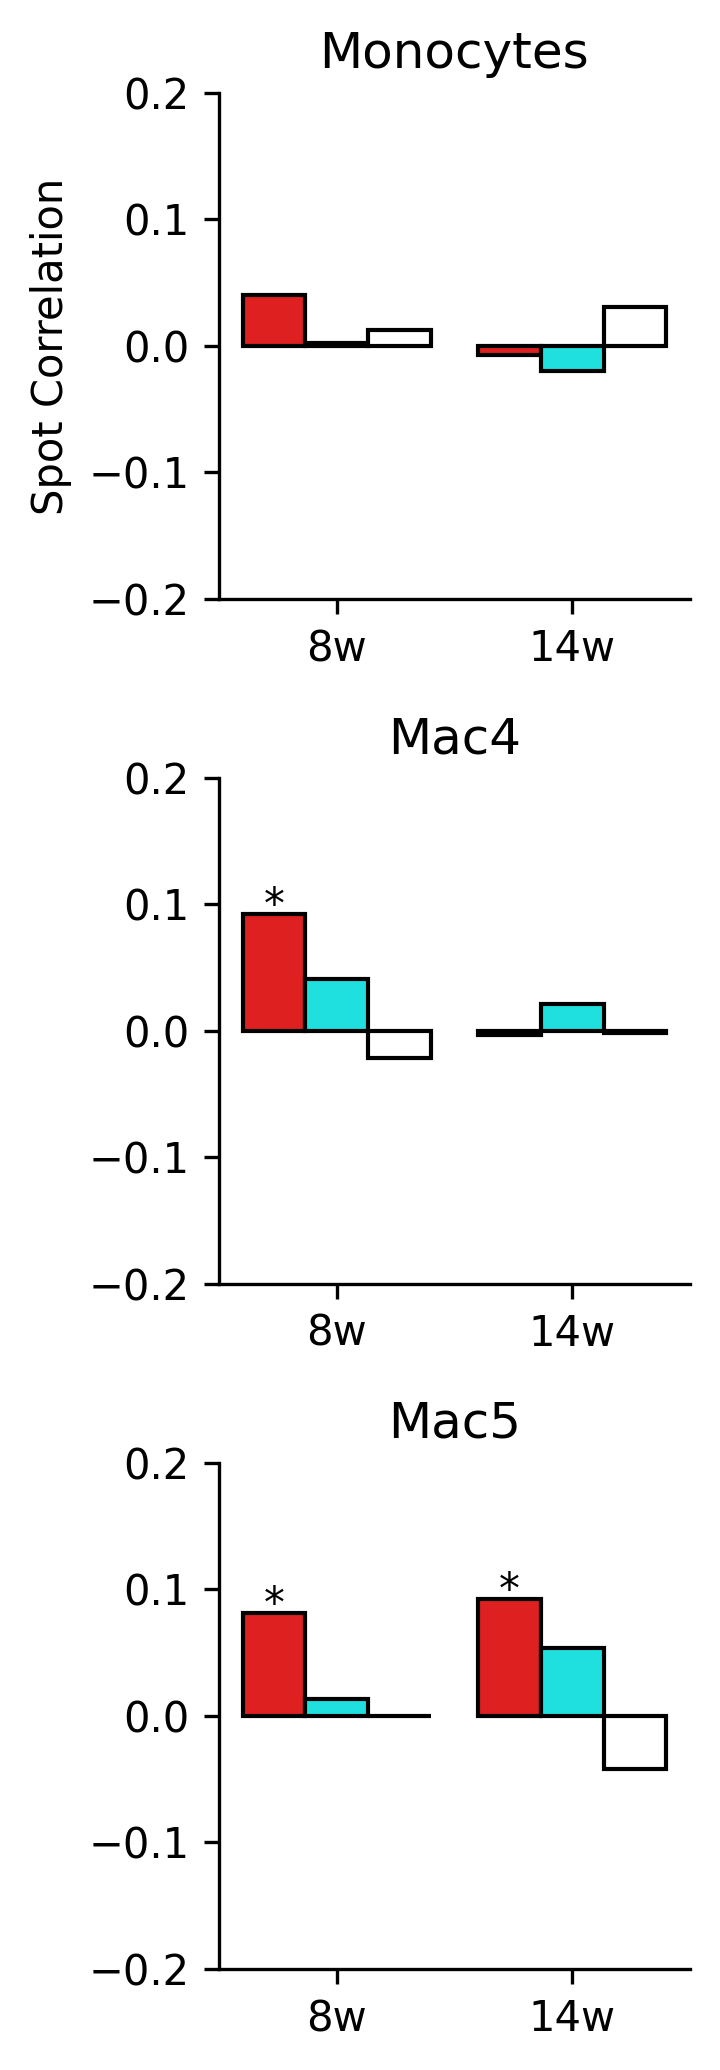

In [19]:
alpha = 0.01

pdf = res.copy()
pdf = pdf.fillna(0)

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

labelMap = {
    1 : r"CLS_${hi}$",
    2 : r"CLS_${mid}$",
    3 : r"background",
    4 : r"adipocyte",
}


nres = []

for key in ['HFD8', 'HFD14']:
    for lt in [1, 2, 4]:
        for ct in ['Monocytes', 'Mac4', 'Mac5']:    
            cx = pdf[pdf['key'] == key]
            
            stat, pval = scipy.stats.pearsonr(cx[lt], cx[ct])
            
            row = {
                'key' : key,
                'keyName' : keyMap[key],
                'label' : lt,
                'labelName' : labelMap[lt],
                'cellType' : ct,
                'stat' : stat,
                'pval' : pval,
            }
            
            nres.append(row)
            
            
nres = pd.DataFrame(nres)
nres.head()

plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 7, 2.5
plt.rcParams['figure.figsize'] = 2.5, 7
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(3, 1)
axs = axs.ravel()

for i, ct in enumerate(['Monocytes', 'Mac4', 'Mac5']):   
    cx = nres[nres['cellType'] == ct].reset_index()
    
    cx['sig'] = np.where(cx['pval'] < alpha, "*", "")

    g = sns.barplot(data=cx, 
                       x='keyName',
                       y='stat',
                       ec='k',
                       hue='labelName',
                       palette= ["red", "cyan", "w"], 
                       ax=axs[i])
    
    for j, p in enumerate(g.patches):
        
        corr = p.get_height()
        s = cx.loc[cx['stat'] == corr]['sig'].values[0]
        r = cx.loc[cx['stat'] == corr]['stat'].values[0]
        pad = 2
        if r < 0:
            pad = -6
            
        g.annotate(s, 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', 
                   va = 'center', 
                   xytext = (0, pad), 
                   textcoords = 'offset points')
   
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_title(ct)
    axs[i].set_ylim([-0.2, 0.2])
    axs[i].legend().remove()
    axs[i].set_ylabel("Spot Correlation")
    if not i == 0:
        axs[i].set_ylabel("")
    
sns.despine()
# sns.move_legend(axs[0],
#                 title="",
#                 frameon=False,
#                 loc='upper right',
#                 bbox_to_anchor=(2, 1.4))
plt.tight_layout()

In [21]:

pdf = nres.copy()
outdir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/FIG6/"
fname = "proportions.csv"
pdf.to_csv(f"{outdir}{fname}", index=False)
pdf.head()



,key,keyName,label,labelName,cellType,stat,pval
0,HFD8,8w,1,CLS_${hi}$,Monocytes,0.040043,1.965322e-02
1,HFD8,8w,1,CLS_${hi}$,Mac4,0.092510,6.698479e-08
2,HFD8,8w,1,CLS_${hi}$,Mac5,0.081311,2.104428e-06
3,HFD8,8w,2,CLS_${mid}$,Monocytes,0.002431,8.874100e-01
4,HFD8,8w,2,CLS_${mid}$,Mac4,0.040941,1.706584e-02


In [ ]:
break

# randomly segemented images?

(2000, 1628)
(2000, 1628)


(300.0, 1400.0, 1650.0, 350.0)

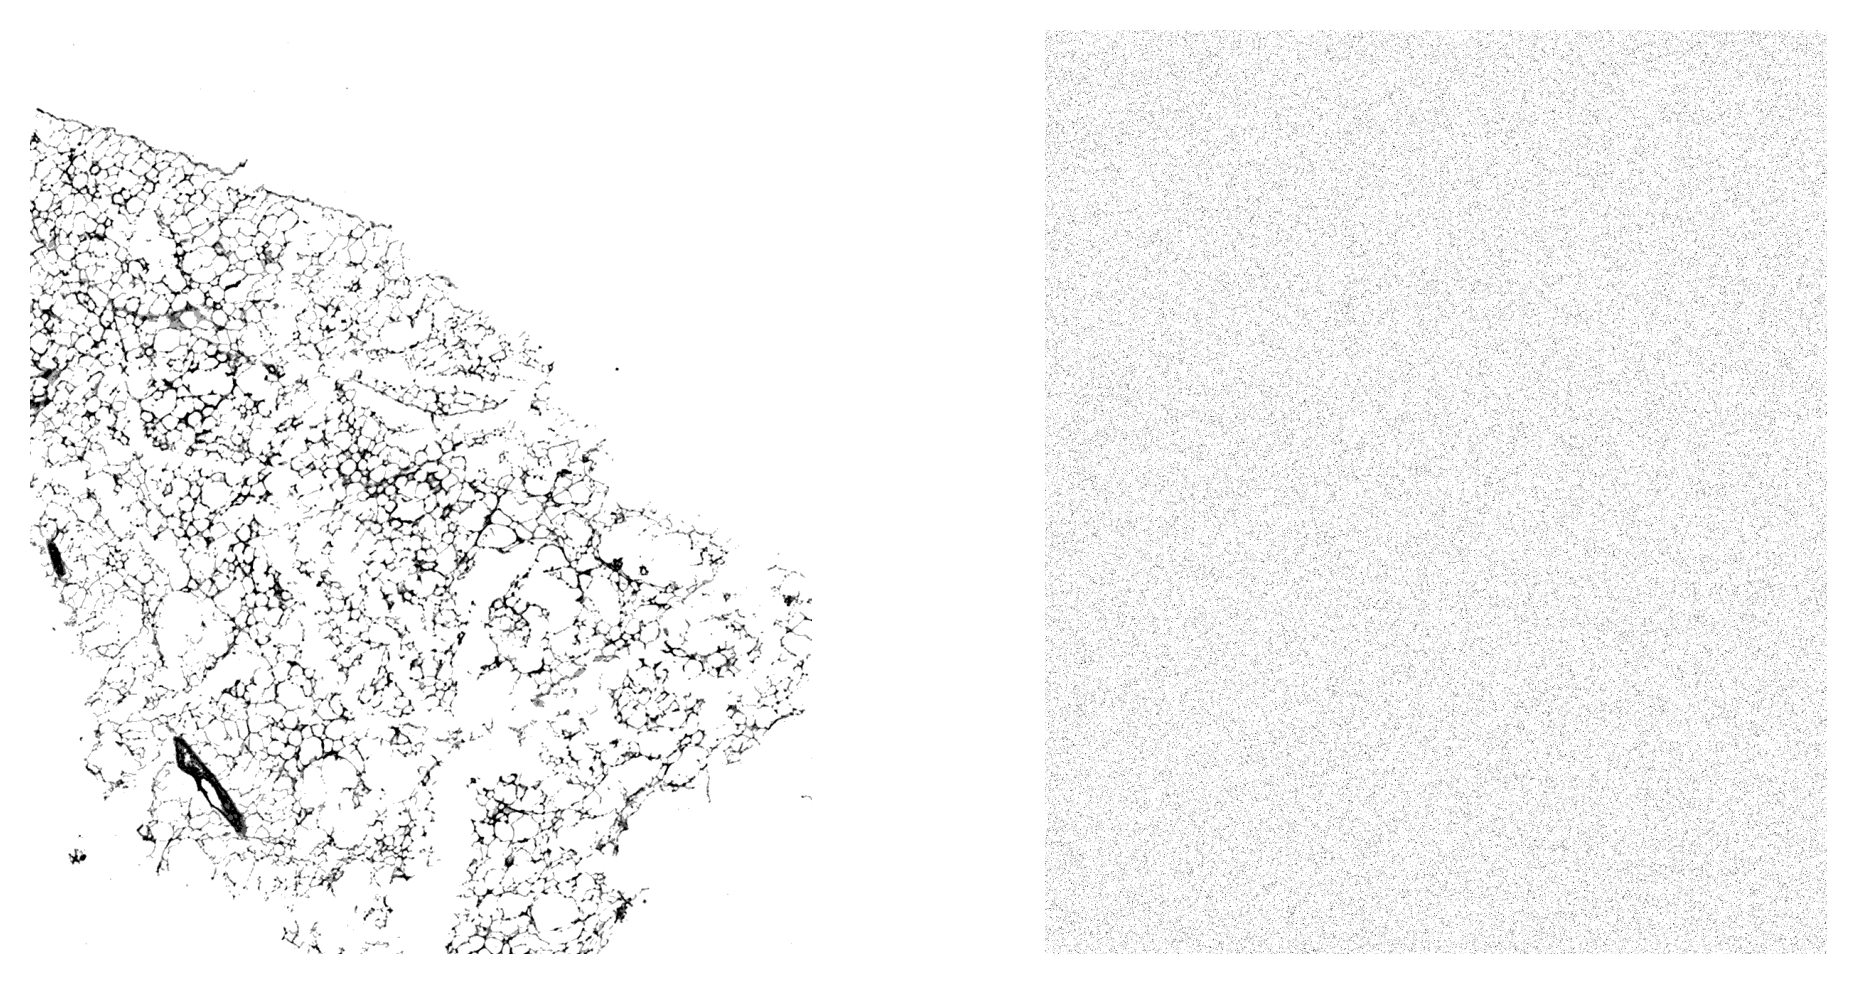

In [22]:
"""shuffle the reference images """

randSeg = {}

for key in keys:
    newSeg = segment[key].copy()
    imShape = newSeg.shape
    # flatten and shuffle
    newSeg = newSeg.ravel()
    np.random.shuffle(newSeg)  
    newSeg = newSeg.reshape(imShape)
    randSeg[key] = newSeg
    

key = 'HFD14'

print(segment[key].shape)
print(randSeg[key].shape)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 4
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(1, 2)

axs[0].imshow(segment[key], cmap='binary_r')
axs[0].set_ylim([1650, 350])
axs[0].set_xlim([300, 1400])
axs[0].axis(False)

axs[1].imshow(randSeg[key], cmap='binary_r')
axs[1].set_ylim([1650, 350])
axs[1].set_xlim([300, 1400])
axs[1].axis(False)



In [23]:
# global image quant
microns = 150 # the physical size of the window

res = []


for key in keys:
    
    print(f"Working {key}...")
    
    # get window size based on physical units
    ultra = hires[key]
    img = lowres[key]
    pixelsPerMicron = getscalebar(key, 1)
    ws = int((microns * pixelsPerMicron) / 2)
    
    
    print(f"{microns=} {pixelsPerMicron=:.3f} {ws=}")
    
    kdf = df[df['key'] == key].reset_index(drop=True)
    
    # fillImg = hires[key]
    # fillImg = lowres[key]
    
    for idx, row in kdf.iterrows():
        # get coordinates
        x = int(row['x'])
        y = int(row['y'])
        xLb = int(x) - ws
        xUb = int(x) + ws   
        yLb = int(y) - ws   
        yUb = int(y) + ws
        
        # predict on window
        window = randSeg[key][yLb:yUb, xLb:xUb]
        # features = features_func(window)
        # result = future.predict_segmenter(features, clf)
        
        # store results
        newRow = {}       
        for k, v in Counter(window.ravel()).items():
            newRow[k] = v / window.size
        
        newRow['key'] = key
        newRow['spotId'] = row['spotId']
        newRow['Mac4'] = row['Mac4']
        newRow['Mac5'] = row['Mac5']
        newRow['Monocytes'] = row['Monocytes']
        res.append(newRow)
        

res = pd.DataFrame(res)
res.head()

Working ND...
microns=150 pixelsPerMicron=0.237 ws=17
Working HFD8...
microns=150 pixelsPerMicron=0.239 ws=17
Working HFD14...
microns=150 pixelsPerMicron=0.230 ws=17


,4,2,3,1,key,spotId,Mac4,Mac5,Monocytes
0,0.899654,0.037197,0.059689,0.003460,ND,AAACAAGTATCTCCCA.1_ND,0.045516,0.027211,0.070782
1,0.900519,0.025952,0.072664,0.000865,ND,AAACAGCTTTCAGAAG.1_ND,0.020027,0.028094,0.089932
2,0.904844,0.024221,0.070069,0.000865,ND,AAACAGGGTCTATATT.1_ND,0.042051,0.033598,0.117606
3,0.902249,0.026817,0.067474,0.003460,ND,AAACATTTCCCGGATT.1_ND,0.087758,0.049242,0.087019
4,0.892734,0.022491,0.083910,0.000865,ND,AAACCCGAACGAAATC.1_ND,0.023106,0.019336,0.038020


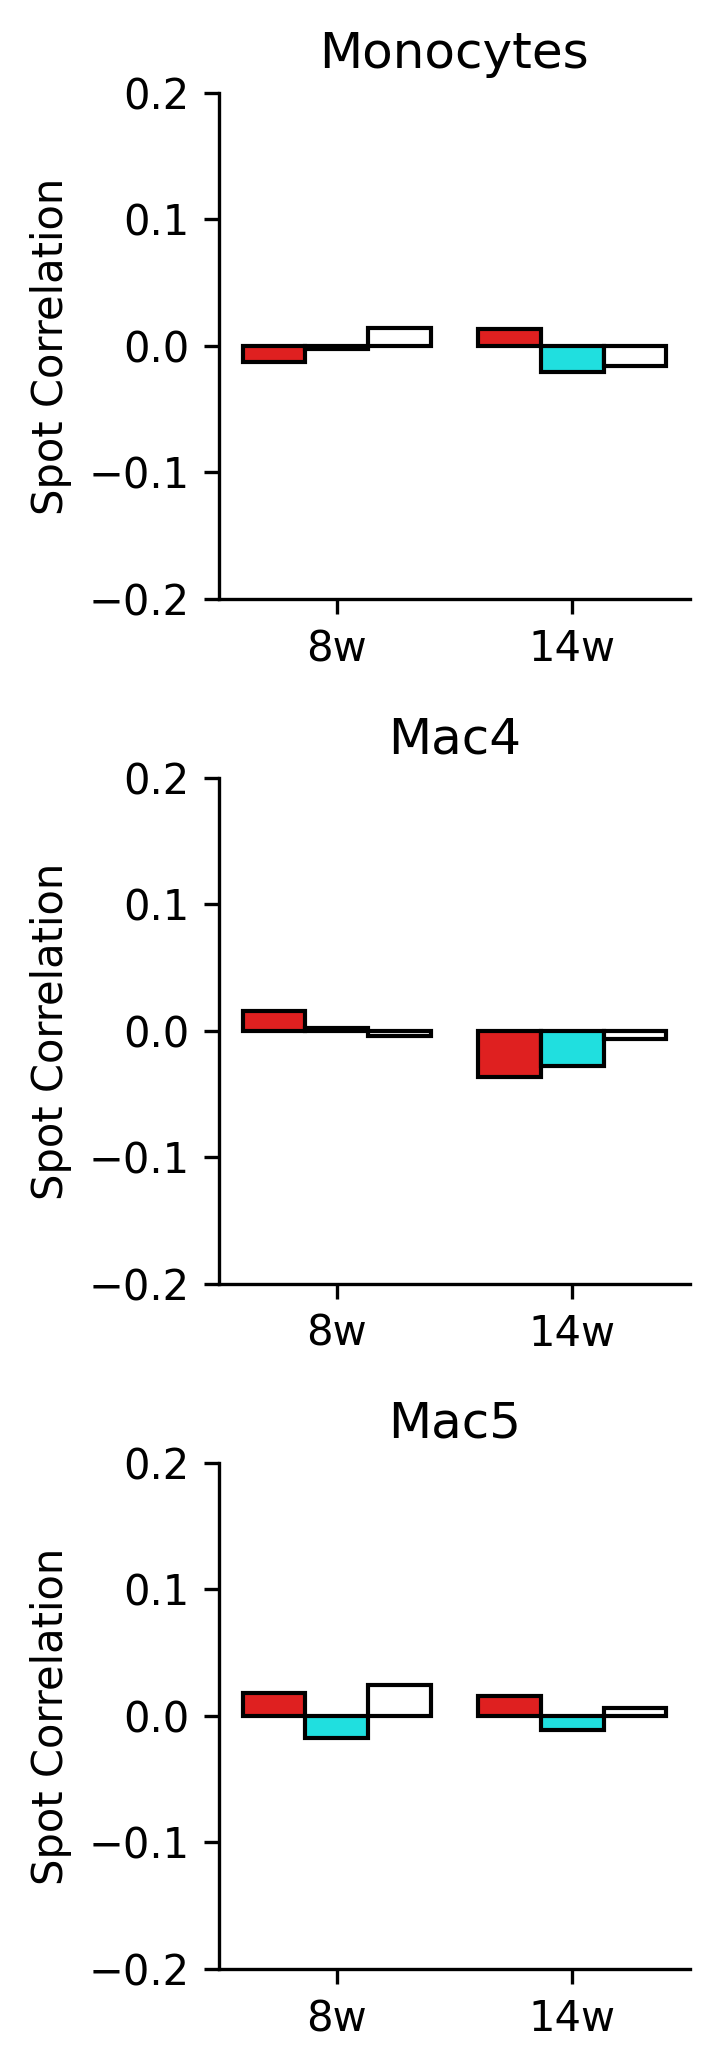

In [24]:
alpha = 0.01

pdf = res.copy()
pdf = pdf.fillna(0)

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

nres = []

for key in ['HFD8', 'HFD14']:
    for lt in [1, 2, 4]:
        for ct in ['Monocytes', 'Mac4', 'Mac5']:    
            cx = pdf[pdf['key'] == key]
            
            stat, pval = scipy.stats.pearsonr(cx[lt], cx[ct])
            
            row = {
                'key' : key,
                'keyName' : keyMap[key],
                'label' : lt,
                'labelName' : labelMap[lt],
                'cellType' : ct,
                'stat' : stat,
                'pval' : pval,
            }
            
            nres.append(row)
            
            
nres = pd.DataFrame(nres)
nres.head()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2.5, 7
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(3, 1)
axs = axs.ravel()

for i, ct in enumerate(['Monocytes', 'Mac4', 'Mac5']):   
    cx = nres[nres['cellType'] == ct].reset_index()
    
    cx['sig'] = np.where(cx['pval'] < alpha, "*", "")

    g = sns.barplot(data=cx, 
                       x='keyName',
                       y='stat',
                       ec='k',
                       hue='labelName',
                       palette= ["red", "cyan", "w"], 
                       ax=axs[i])
    
    for j, p in enumerate(g.patches):
        
        corr = p.get_height()
        s = cx.loc[cx['stat'] == corr]['sig'].values[0]
        r = cx.loc[cx['stat'] == corr]['stat'].values[0]
        pad = 2
        if r < 0:
            pad = -6
            
        g.annotate(s, 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', 
                   va = 'center', 
                   xytext = (0, pad), 
                   textcoords = 'offset points')
   
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_title(ct)
    axs[i].set_ylim([-0.2, 0.2])
    # if not i == 0:
    axs[i].legend().remove()
    axs[i].set_ylabel("Spot Correlation")
    
sns.despine()
# sns.move_legend(axs[0],
#                 title="",
#                 frameon=False,
#                 loc='upper right',
#                 bbox_to_anchor=(2, 1.4))
plt.tight_layout()

In [ ]:
break

# Mac 5 Networks

In [25]:
def closest_node(node, nodes, metric):
    closest_index = distance.cdist([node], nodes, metric=metric).argmin()
    return closest_index

def getGraph(kdf, x, y, n=300, metric='minkowski', return_center=True):
    """A function to generate a graph of size n x n
    around point (x, y) """
    
    nodes = kdf[['x', 'y']]
    centerInd = closest_node([x, y], nodes, metric)
    
      
    # get the n points around that node
    nbrs = NearestNeighbors(n_neighbors=n,  
                            metric=metric, 
                            algorithm='ball_tree').fit(nodes)
    distances, indices = nbrs.kneighbors(nodes)
    
    # create the subgraph
    windowIndices = indices[centerInd]
    mask = kdf.index.isin(windowIndices)
    
    center = kdf[mask].reset_index(drop=True)
    dists = sklearn.metrics.pairwise_distances(center[['x', 'y']], metric=metric)
    
    X = dists
    
    # create the graph
    nodeMapper = dict(zip(center.index, center['spotId']))
    G = nx.from_numpy_array(X)
    G = nx.relabel_nodes(G, nodeMapper)
    
    # set positions
    pos = {}
    for idx, row in center.iterrows():
        pos[row['spotId']] = np.array(row[['x', 'y']])
    
    G.pos = pos
    
    if return_center:
        return G, center
    else:
        return G
    
    
def getKnn(kdf, k=6, metric='minkowski'):
    """A function to generate a knn graph """
    
    nodes = kdf[['x', 'y']]
      
    # get the n points around that node
    nbrs = NearestNeighbors(n_neighbors=k+1,  
                            metric=metric, 
                            algorithm='ball_tree').fit(nodes)
    distances, indices = nbrs.kneighbors(nodes)
    return indices


def knnInd2Id(kdf, knnInd):
    """Translate neighbors to spotIds """
    
    transId = {}
    
    for i, row in kdf.iterrows():
        spotId = row['spotId']
        nbrhs = kdf.iloc[knnInd[i]]['spotId'].values
        transId[spotId] = nbrhs
    return transId
    
    

def blur(sdf, transId):
    """A function to blur all columns using their neighbors.
    Expects spotIds as index """
    
    results  = []
    
    for spotId, nbhs in transId.items():
        
        t = sdf.loc[nbhs].mean().to_dict()
        t['spotId'] = spotId
        results.append(t)
        
    results = pd.DataFrame(results)
    results = results.set_index('spotId')
    return results


def getCentralities(G):
    """ function to compute centralities """
    cf = pd.DataFrame({'spotId' : G.nodes()})
    cf['degree_centrality'] = cf['spotId'].map(nx.degree_centrality(G))
    cf['betweenness_centrality'] = cf['spotId'].map(nx.betweenness_centrality(G))
    cf['closeness_centrality'] = cf['spotId'].map(nx.closeness_centrality(G))
    cf['harmonic_centrality'] = cf['spotId'].map(nx.harmonic_centrality(G))
    cf['harmonic_centrality'] = cf['spotId'].map(nx.harmonic_centrality(G))
    cf['eigenvector_centrality'] = cf['spotId'].map(nx.eigenvector_centrality(G, tol=0.001))
    return cf

In [26]:
# sampling networks 

keys = ['ND', 'HFD8', 'HFD14']

field = "Mac5" # the column to define edgeweights
networkSize = 150
nNetworks = 200 # from each time point
edgeRadius = 25 # distance between spots
edgeThresh = 0.01

graph = {}
meta = {}
deets = {}

keyInds = np.random.choice(list(range(len(keys))), nNetworks, replace=True)

for i, key in enumerate(keys):

    kdf = df[df['key'] == key].reset_index(drop=True)
    
    for s in range(nNetworks):
        sample = kdf.sample(1)
        sx = sample['x'].values[0]
        sy = sample['y'].values[0]
    
        # generate the graph 
        G, mf = getGraph(kdf, sx, sy, networkSize)

        # # define the node properties
        # mf['norm'] = mf['Mac5'] / mf['Mac5'].max()

        node_attr = mf.set_index('spotId').to_dict('index')
        nx.set_node_attributes(G, node_attr)    

        # define connections
        edgelist = []
        for u,v,e in G.edges(data=True):
            if e['weight'] < edgeRadius:
                x1 = G.nodes[u][field]
                x2 = G.nodes[v][field]

                mean = scipy.stats.hmean([x1, x2])
                # edgelist.append((u, v, mean))
                if mean < edgeThresh:
                    edgelist.append((u, v, mean))

        # build the new graph based on connections
        H = nx.Graph()
        H.add_nodes_from(G.nodes())
        H.add_weighted_edges_from(edgelist)
        H.pos = G.pos 

        # add centralities
        cf = getCentralities(H)

        node_attr = cf.set_index('spotId').to_dict('index')
        nx.set_node_attributes(H, node_attr)    

        mf = pd.merge(mf, cf, 
                      left_on='spotId', 
                      right_on='spotId', 
                      how='left')

        graph[key, s] = H
        meta[key, s] = mf
        deets[key, s] = {
            'key' : key,
            'x' : sx,
            'y' : sy,
        }


conNodes = {
    'ND' : [],
    'HFD8' : [],
    'HFD14' : [],
}

deconNodes = {
    'ND' : [],
    'HFD8' : [],
    'HFD14' : [],
}

T = 1

for (key, gid), G in graph.items():
    # add connected nodes
    nids = [nid for nid, deg in G.degree() if deg > T]
    conNodes[key] += nids
    
    # add disconnected nodes
    nids = [nid for nid, deg in G.degree() if deg < T]
    deconNodes[key] += nids
    
    
# resolve overlap    
for key in keys:
    con = list(set(conNodes[key]))
    decon = list(set([x for x in deconNodes[key] if not x in con]))
    con = list(set([x for x in con if not x in decon]))
    print(f"{key=} {len(con)=} {len(decon)=}")
    
    conNodes[key] = con
    deconNodes[key] = decon

key='ND' len(con)=729 len(decon)=1086
key='HFD8' len(con)=47 len(decon)=3262
key='HFD14' len(con)=40 len(decon)=1920


In [27]:
microns = 150 # the physical size of the window
res = []

for key in keys:
    
    # get the connected and disconnected nodes
    kdf = df[df['key'] == key].reset_index(drop=True)
    condf = kdf[kdf['spotId'].isin(conNodes[key])].reset_index(drop=True)
    condf['type'] = 'connected'
    decondf =  kdf[kdf['spotId'].isin(deconNodes[key])].reset_index(drop=True)
    decondf['type'] = 'disconnected'
    
    cdf = pd.concat([condf, decondf])

    # get window size based on physical units
    ultra = hires[key]
    img = lowres[key]
    pixelsPerMicron = getscalebar(key, 1)
    ws = int((microns * pixelsPerMicron) / 2)
    
    print(f"{microns=} {pixelsPerMicron=:.3f} {ws=}")
    
    for idx, row in cdf.iterrows():
        # get coordinates
        x = int(row['x'])
        y = int(row['y'])
        xLb = int(x) - ws
        xUb = int(x) + ws   
        yLb = int(y) - ws   
        yUb = int(y) + ws
        
        # predict on window
        window = segment[key][yLb:yUb, xLb:xUb]
        
        # store results
        newRow = {}       
        for k, v in Counter(window.ravel()).items():
            newRow[k] = v / window.size
        
        newRow['key'] = key
        newRow['spotId'] = row['spotId']
        newRow['type'] = row['type']
        newRow['Mac5'] = row['Mac5']
        newRow['Mac4'] = row['Mac4']
        res.append(newRow)

res = pd.DataFrame(res)
res.head()

microns=150 pixelsPerMicron=0.237 ws=17
microns=150 pixelsPerMicron=0.239 ws=17
microns=150 pixelsPerMicron=0.230 ws=17


,4,3,2,1,key,spotId,type,Mac5,Mac4
0,0.859862,0.091696,0.037197,0.011246,ND,AAACCGGGTAGGTACC.1_ND,connected,0.007613,0.012176
1,0.891003,0.068339,0.025087,0.015571,ND,AAACCGTTCGTCCAGG.1_ND,connected,0.018913,0.028858
2,0.793253,0.154844,0.046713,0.005190,ND,AAACTCGGTTCGCAAT.1_ND,connected,0.002825,0.015316
3,0.879758,0.086505,0.029412,0.004325,ND,AAAGGCTCTCGCGCCG.1_ND,connected,0.001749,0.001799
4,0.702422,0.199827,0.084775,0.012976,ND,AAATAGGGTGCTATTG.1_ND,connected,0.023299,0.026811


H0: imean=0.043 == outmean=0.022 (pval=0.06754992333288383) foldchange=1.936


Text(0, 0.5, 'CLS$_{hi}$ Pixels per 150$\\mu m^2$')

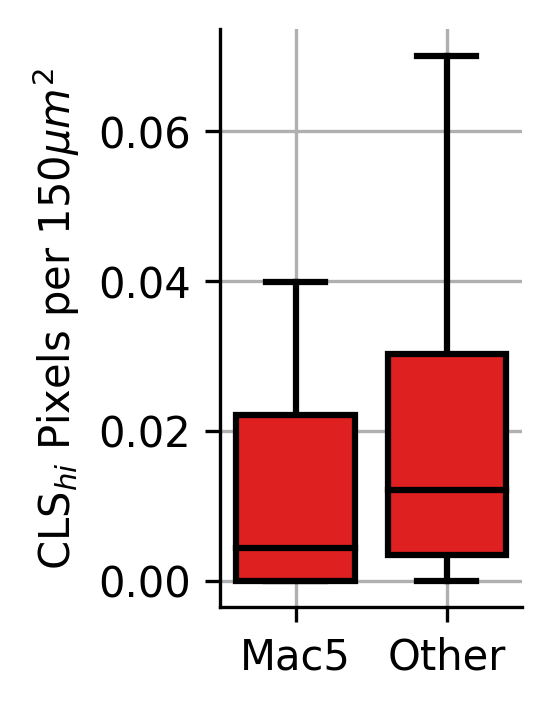

In [28]:
pdf = res.copy()
pdf = pdf.fillna(0)

labelMap = {
    1 : r"CLS$_{hi}$",
    2 : r"CLS$_{mid}$",
    3 : r"background",
    4 : r"adipocyte",
}

ltype = 1

# melt the data
pdf = pd.melt(pdf, id_vars=['spotId', 'key', 'type', 'Mac5', 'Mac4'])
pdf = pdf[pdf['variable'] == ltype]
pdf = pdf[pdf['key'].isin(["HFD8", "HFD14"])]

""" T Test of differences """
mask = (pdf['type'] == 'connected')
inNet = pdf[mask]
outNet = pdf[~mask]

stat, pval = scipy.stats.ttest_ind(inNet['value'],
                                   outNet['value'],
                                   equal_var=False,)

imean = inNet['value'].mean()
outmean = outNet['value'].mean()
foldchange = imean / outmean
print(f"H0: {imean=:.3f} == {outmean=:.3f} ({pval=}) {foldchange=:.3f}")

nameMap = {
    'connected' : "Mac5",
    'disconnected' : "Other",
}

pdf['names'] = pdf['type'].map(nameMap)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.3, 2.5
plt.rcParams['figure.facecolor'] = "w"

sns.boxplot(data=pdf, 
             x='names',
             y='value',
             showfliers=False,
             boxprops={'edgecolor':'k', 'zorder':3},
             medianprops={'color':'k', 'zorder':4},
             whiskerprops={'color':'k'},
             capprops={'color':'k'},
             hue='variable',
             palette=colors[ltype-1:4])

plt.gca().grid(True, zorder=0)
sns.despine()
plt.gca().legend().remove()
plt.xlabel("")
plt.ylabel(f"{labelMap[ltype]} Pixels per {microns}$\mu m^2$")

pval=0.00000 foldchange=7.786


Text(0, 0.5, 'CLS$_{mid}$ per 150$\\mu m^2$')

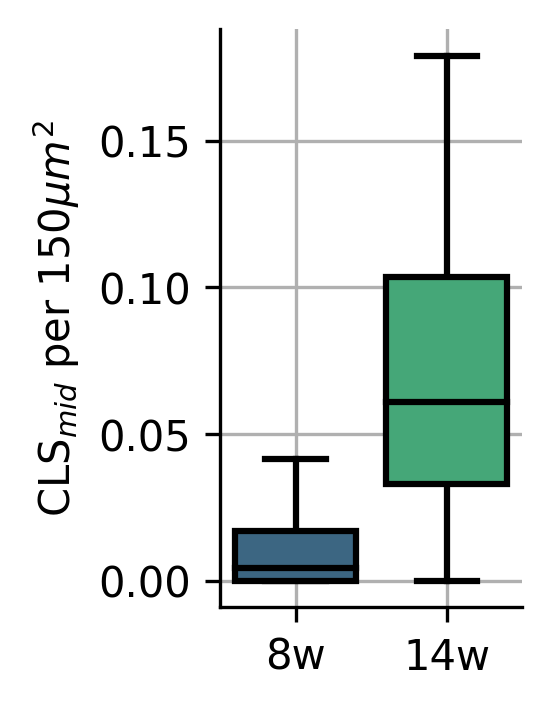

In [29]:
pdf = res.copy()
pdf = pdf.fillna(0)

ltype = 2

pdf = pdf[pdf['key'].isin(["HFD8", "HFD14"])]
pdf = pdf[pdf['type'] == 'connected']

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

pdf['keyName'] = pdf['key'].map(keyMap)


mask = (pdf['key'] == 'HFD14')

inNet = pdf[mask]
outNet = pdf[~mask]
stat, pval = scipy.stats.ttest_ind(inNet[ltype],
                                   outNet[ltype])

foldchange = inNet[ltype].mean() / outNet[ltype].mean()
print(f"{pval=:.5f} {foldchange=:.3f}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.3, 2.5
plt.rcParams['figure.facecolor'] = "w"


sns.boxplot(data=pdf,
            y=ltype,
            x='keyName',
            dodge=False,
            boxprops={'edgecolor':'k', 'zorder':3},
            medianprops={'color':'k', 'zorder':4},
            whiskerprops={'color':'k'},
            capprops={'color':'k'},
            showfliers=False,
            hue='key',
            palette='viridis',)

plt.gca().grid(True, zorder=0)
plt.gca().legend().remove()
plt.xlabel("")
# plt.xlabel(labelMap[1])
sns.despine()

plt.ylabel(f"{labelMap[ltype]} per {microns}$\mu m^2$")

In [ ]:
break

# Macrophages and the Random Image

In [30]:
microns = 150 # the physical size of the window
res = []

for key in keys:
    
    # get the connected and disconnected nodes
    kdf = df[df['key'] == key].reset_index(drop=True)
    condf = kdf[kdf['spotId'].isin(conNodes[key])].reset_index(drop=True)
    condf['type'] = 'connected'
    decondf =  kdf[kdf['spotId'].isin(deconNodes[key])].reset_index(drop=True)
    decondf['type'] = 'disconnected'
    
    cdf = pd.concat([condf, decondf])

    # get window size based on physical units
    ultra = hires[key]
    img = lowres[key]
    pixelsPerMicron = getscalebar(key, 1)
    ws = int((microns * pixelsPerMicron) / 2)
    
    print(f"{microns=} {pixelsPerMicron=:.3f} {ws=}")
    
    for idx, row in cdf.iterrows():
        # get coordinates
        x = int(row['x'])
        y = int(row['y'])
        xLb = int(x) - ws
        xUb = int(x) + ws   
        yLb = int(y) - ws   
        yUb = int(y) + ws
        
        # predict on window
        window = randSeg[key][yLb:yUb, xLb:xUb]
        
        # store results
        newRow = {}       
        for k, v in Counter(window.ravel()).items():
            newRow[k] = v / window.size
        
        newRow['key'] = key
        newRow['spotId'] = row['spotId']
        newRow['type'] = row['type']
        newRow['Mac5'] = row['Mac5']
        newRow['Mac4'] = row['Mac4']
        res.append(newRow)

res = pd.DataFrame(res)
res.head()

microns=150 pixelsPerMicron=0.237 ws=17
microns=150 pixelsPerMicron=0.239 ws=17
microns=150 pixelsPerMicron=0.230 ws=17


,4,3,1,2,key,spotId,type,Mac5,Mac4
0,0.909170,0.061419,0.005190,0.024221,ND,AAACCGGGTAGGTACC.1_ND,connected,0.007613,0.012176
1,0.897924,0.073529,0.000865,0.027682,ND,AAACCGTTCGTCCAGG.1_ND,connected,0.018913,0.028858
2,0.903979,0.067474,0.001730,0.026817,ND,AAACTCGGTTCGCAAT.1_ND,connected,0.002825,0.015316
3,0.906574,0.067474,0.005190,0.020761,ND,AAAGGCTCTCGCGCCG.1_ND,connected,0.001749,0.001799
4,0.903979,0.070069,0.003460,0.022491,ND,AAATAGGGTGCTATTG.1_ND,connected,0.023299,0.026811


H0: imean=0.008 == outmean=0.008 (pval=0.6410583407983589) foldchange=1.020


Text(0.5, 1.0, 'RANDOM PERMUTATION')

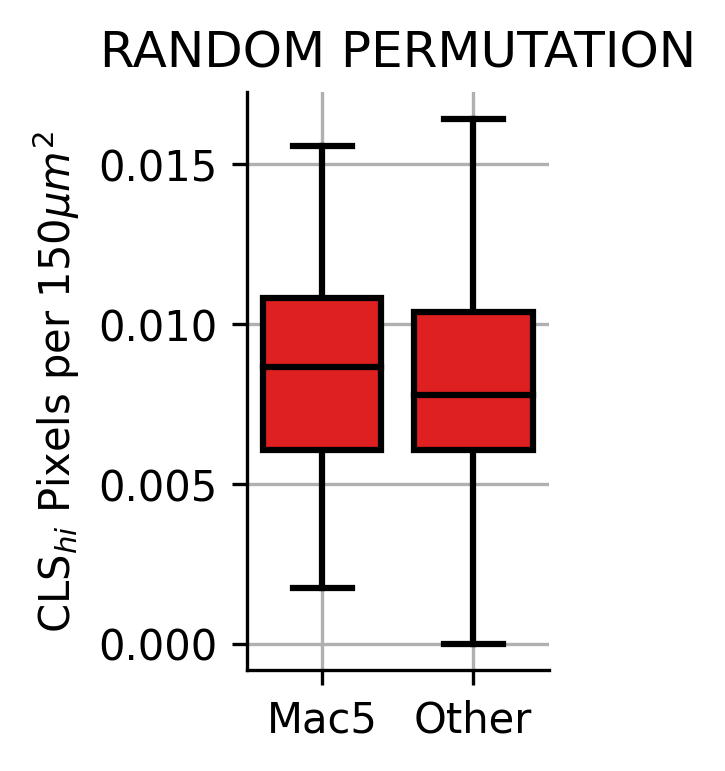

In [31]:
pdf = res.copy()
pdf = pdf.fillna(0)

ltype = 1


# melt the data
pdf = pd.melt(pdf, id_vars=['spotId', 'key', 'type', 'Mac5', 'Mac4'])
pdf = pdf[pdf['variable'] == ltype]
pdf = pdf[pdf['key'].isin(["HFD8", "HFD14"])]


""" T Test of differences """
mask = (pdf['type'] == 'connected')
inNet = pdf[mask]
outNet = pdf[~mask]

stat, pval = scipy.stats.ttest_ind(inNet['value'],
                                   outNet['value'],
                                   equal_var=False,)

imean = inNet['value'].mean()
outmean = outNet['value'].mean()
foldchange = imean / outmean
print(f"H0: {imean=:.3f} == {outmean=:.3f} ({pval=}) {foldchange=:.3f}")


nameMap = {
    'connected' : "Mac5",
    'disconnected' : "Other",
}

pdf['names'] = pdf['type'].map(nameMap)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.3, 2.5
plt.rcParams['figure.facecolor'] = "w"

sns.boxplot(data=pdf, 
             x='names',
             y='value',
             showfliers=False,
             boxprops={'edgecolor':'k', 'zorder':3},
             medianprops={'color':'k', 'zorder':4},
             whiskerprops={'color':'k'},
             capprops={'color':'k'},
             hue='variable',
             palette=colors[ltype-1:4])

plt.gca().grid(True, zorder=0)
sns.despine()
plt.gca().legend().remove()
plt.xlabel("")
plt.ylabel(f"{labelMap[ltype]} Pixels per {microns}$\mu m^2$")
plt.title("RANDOM PERMUTATION")

In [ ]:
break

# Mac4

In [ ]:
# # sampling networks 

# keys = ['ND', 'HFD8', 'HFD14']

# field = "Mac4" # the column to define edgeweights
# networkSize = 150
# nNetworks = 200 # from each time point
# edgeRadius = 25 # distance between spots
# sampleSigma = 0.1 # variance around the center of the image
# edgeThresh = 0.1
# # edgeThresh = 0.15

# graph = {}
# meta = {}
# deets = {}

# keyInds = np.random.choice(list(range(len(keys))), nNetworks, replace=True)

# for i, key in enumerate(keys):

#     kdf = df[df['key'] == key].reset_index(drop=True)
    
#     for s in range(nNetworks):
#         sample = kdf.sample(1)
#         sx = sample['x'].values[0]
#         sy = sample['y'].values[0]
    
#         # generate the graph 
#         G, mf = getGraph(kdf, sx, sy, networkSize)

#         # # define the node properties
#         # mf['norm'] = mf['Mac5'] / mf['Mac5'].max()

#         node_attr = mf.set_index('spotId').to_dict('index')
#         nx.set_node_attributes(G, node_attr)    

#         # define connections
#         edgelist = []
#         for u,v,e in G.edges(data=True):
#             if e['weight'] < edgeRadius:
#                 x1 = G.nodes[u][field]
#                 x2 = G.nodes[v][field]

#                 mean = scipy.stats.hmean([x1, x2])
#                 # edgelist.append((u, v, mean))
#                 if mean > edgeThresh:
#                     edgelist.append((u, v, mean))

#         # build the new graph based on connections
#         H = nx.Graph()
#         H.add_nodes_from(G.nodes())
#         H.add_weighted_edges_from(edgelist)
#         H.pos = G.pos 

#         # add centralities
#         cf = getCentralities(H)

#         node_attr = cf.set_index('spotId').to_dict('index')
#         nx.set_node_attributes(H, node_attr)    

#         mf = pd.merge(mf, cf, 
#                       left_on='spotId', 
#                       right_on='spotId', 
#                       how='left')

#         graph[key, s] = H
#         meta[key, s] = mf
#         deets[key, s] = {
#             'key' : key,
#             'x' : sx,
#             'y' : sy,
#         }

# print('done')

In [ ]:
# conNodes = {
#     'ND' : [],
#     'HFD8' : [],
#     'HFD14' : [],
# }

# deconNodes = {
#     'ND' : [],
#     'HFD8' : [],
#     'HFD14' : [],
# }

# T = 1

# for (key, gid), G in graph.items():
    
#     # add connected nodes
#     nids = [nid for nid, deg in G.degree() if deg > T]
#     conNodes[key] += nids
    
#     # add disconnected nodes
#     nids = [nid for nid, deg in G.degree() if deg < T]
#     deconNodes[key] += nids
    
    
# # resolve overlap    
# for key in keys:
#     con = list(set(conNodes[key]))
#     decon = list(set([x for x in deconNodes[key] if not x in con]))
#     con = list(set([x for x in con if not x in decon]))
#     print(f"{key=} {len(con)=} {len(decon)=}")
    
    
#     conNodes[key] = con
#     deconNodes[key] = decon

In [ ]:
# microns = 150 # the physical size of the window
# res = []

# for key in keys:
    
#     # get the connected and disconnected nodes
#     kdf = df[df['key'] == key].reset_index(drop=True)
#     condf = kdf[kdf['spotId'].isin(conNodes[key])].reset_index(drop=True)
#     condf['type'] = 'connected'
#     decondf =  kdf[kdf['spotId'].isin(deconNodes[key])].reset_index(drop=True)
#     decondf['type'] = 'disconnected'
    
#     cdf = pd.concat([condf, decondf])

#     # get window size based on physical units
#     ultra = hires[key]
#     img = lowres[key]
#     pixelsPerMicron = getscalebar(key, 1)
#     ws = int((microns * pixelsPerMicron) / 2)
    
#     print(f"{microns=} {pixelsPerMicron=:.3f} {ws=}")
    
#     for idx, row in cdf.iterrows():
#         # get coordinates
#         x = int(row['x'])
#         y = int(row['y'])
#         xLb = int(x) - ws
#         xUb = int(x) + ws   
#         yLb = int(y) - ws   
#         yUb = int(y) + ws
        
#         # predict on window
#         window = segment[key][yLb:yUb, xLb:xUb]
        
#         # store results
#         newRow = {}       
#         for k, v in Counter(window.ravel()).items():
#             newRow[k] = v / window.size
        
#         newRow['key'] = key
#         newRow['spotId'] = row['spotId']
#         newRow['type'] = row['type']
#         newRow['Mac5'] = row['Mac5']
#         newRow['Mac4'] = row['Mac4']
#         res.append(newRow)

# res = pd.DataFrame(res)
# res.head()

In [ ]:
# pdf = res.copy()
# pdf = pdf.fillna(0)

# ltype = 1
# mask = (pdf['type'] == 'connected')

# inNet = pdf[mask]
# outNet = pdf[~mask]

# stat, pval = scipy.stats.ttest_ind(inNet[ltype],
#                                    outNet[ltype])

# foldchange = inNet[ltype].mean() / outNet[ltype].mean()
# print(f"{pval=:.5f} {foldchange=:.3f}")

# # melt the data
# pdf = pd.melt(pdf, id_vars=['spotId', 'key', 'type', 'Mac5', 'Mac4'])
# pdf = pdf[pdf['variable'] == ltype]
# pdf = pdf[pdf['key'].isin(["HFD8", "HFD14"])]

# nameMap = {
#     'connected' : "Mac4",
#     'disconnected' : "Other",
# }

# pdf['names'] = pdf['type'].map(nameMap)


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 1.3, 2.5
# plt.rcParams['figure.facecolor'] = "w"

# sns.boxplot(data=pdf, 
#              x='names',
#              y='value',
#              showfliers=False,
#              boxprops={'edgecolor':'k', 'zorder':3},
#              medianprops={'color':'k', 'zorder':4},
#              whiskerprops={'color':'k'},
#              capprops={'color':'k'},
#              hue='variable',
#              palette=colors[ltype-1:4])

# plt.gca().grid(True, zorder=0)
# sns.despine()
# plt.gca().legend().remove()
# plt.xlabel("")
# plt.ylabel(f"{labelMap[ltype]} Pixels per {microns}$\mu m^2$")

In [ ]:
# pdf = res.copy()
# pdf = pdf.fillna(0)

# ltype = 1

# pdf = pdf[pdf['key'].isin(["HFD8", "HFD14"])]
# pdf = pdf[pdf['type'] == 'connected']

# keyMap = {
#     'ND' : 'ND',
#     'HFD8' : '8w',
#     'HFD14' : '14w',
# }

# pdf['keyName'] = pdf['key'].map(keyMap)


# mask = (pdf['key'] == 'HFD14')

# inNet = pdf[mask]
# outNet = pdf[~mask]
# stat, pval = scipy.stats.ttest_ind(inNet[ltype],
#                                    outNet[ltype])

# foldchange = inNet[ltype].mean() / outNet[ltype].mean()
# print(f"{pval=:.5f} {foldchange=:.3f}")

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 1.3, 2.5
# plt.rcParams['figure.facecolor'] = "w"


# sns.boxplot(data=pdf,
#             y=ltype,
#             x='keyName',
#             dodge=False,
#             boxprops={'edgecolor':'k', 'zorder':3},
#             medianprops={'color':'k', 'zorder':4},
#             whiskerprops={'color':'k'},
#             capprops={'color':'k'},
#             showfliers=False,
#             hue='key',
#             palette='viridis',)

# plt.gca().grid(True, zorder=0)
# plt.gca().legend().remove()
# plt.xlabel("")
# # plt.xlabel(labelMap[1])
# sns.despine()

# plt.ylabel(f"{labelMap[ltype]} per {microns}$\mu m^2$")

# Proportion Analysis

In [ ]:
# pdf = res.copy()

# pdf = pd.melt(pdf, id_vars=['spotId', 'key', 'type', 'Mac5', 'Mac4'])
# pdf = pdf[pdf['variable'] != 4]
# pdf = pdf[pdf['key'].isin(["HFD8", "HFD14"])]

# nameMap = {
#     'connected' : "Mac4 Niche",
#     'disconnected' : "Other",
# }

# pdf['names'] = pdf['type'].map(nameMap)


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 2.5, 3
# plt.rcParams['figure.facecolor'] = "w"

# sns.boxplot(data=pdf, 
#              x='names',
#              y='value',
#              showfliers=False,
#              boxprops={'edgecolor':'k', 'zorder':3},
#              medianprops={'color':'k'},
#              whiskerprops={'color':'k'},
#              capprops={'color':'k'},
#              hue='variable',
#              palette=colors[0:3])

# plt.gca().grid(True, zorder=0)
# sns.despine()
# plt.gca().legend().remove()
# plt.xlabel("")
# plt.ylabel(f"Proportion Pixels per {microns}$\mu m^2$")

In [ ]:
# pdf = res.copy()

# keyMap = {
#     'ND' : 'ND',
#     'HFD8' : '8w',
#     'HFD14' : '14w',
# }

# pdf['keyName'] = pdf['key'].map(keyMap)

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 1.5, 2
# plt.rcParams['figure.facecolor'] = "w"

# ltype = 2

# sns.boxplot(data=pdf,
#             y=ltype,
#             x='keyName',
#             dodge=False,
#             boxprops={'edgecolor':'k', 'zorder':3},
#             medianprops={'color':'k'},
#             whiskerprops={'color':'k'},
#             capprops={'color':'k'},
#             showfliers=False,
#             hue='key',
#             palette='viridis',)

# plt.gca().grid(True, zorder=0)
# plt.gca().legend().remove()
# plt.xlabel("")
# # plt.xlabel(labelMap[1])
# sns.despine()

# plt.ylabel(f"{labelMap[ltype]} per {microns}$\mu m^2$")